In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random

In [18]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...

batch_size = 85
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    'apples_train/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    'apples_test/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = test_datagen.flow_from_directory(
    'eggplant/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

Found 6416 images belonging to 13 classes.
Found 2138 images belonging to 13 classes.
Found 468 images belonging to 3 classes.


In [19]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------
model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 6, 3)           219       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 3)          

In [20]:

# Compile the model
model.compile(optimizer='adadelta', loss='mean_squared_error')

# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'models/model1.h5'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', save_format='h5') # Saves the best version of the model to disk (as measured on the validation data set)
model.fit(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=600,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size,
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/600
11/11 [==============================] - 1s 96ms/step - loss: 0.1196 - val_loss: 0.1209
Epoch 2/600
11/11 [==============================] - 1s 86ms/step - loss: 0.1206 - val_loss: 0.1207
Epoch 3/600
11/11 [==============================] - 1s 81ms/step - loss: 0.1202 - val_loss: 0.1202
Epoch 4/600
11/11 [==============================] - 1s 80ms/step - loss: 0.1203 - val_loss: 0.1200
Epoch 5/600
11/11 [==============================] - 1s 84ms/step - loss: 0.1210 - val_loss: 0.1206
Epoch 6/600
11/11 [==============================] - 1s 81ms/step - loss: 0.1206 - val_loss: 0.1203
Epoch 7/600
11/11 [==============================] - 1s 84ms/step - loss: 0.1198 - val_loss: 0.1206
Epoch 8/600
11/11 [==============================] - 1s 79ms/step - loss: 0.1206 - val_loss: 0.1203
Epoch 9/600
11/11 [==============================] - 1s 78ms/step - loss: 0.1199 - val_loss: 0.1200
Epoch 10/600
11/11 [==============================] - 1s 79ms/step - loss: 0.1196 - val_loss: 0.1194

In [21]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

In [22]:
model_filepath

'models/model1.h5'

3/3 [==============================] - 0s 5ms/step


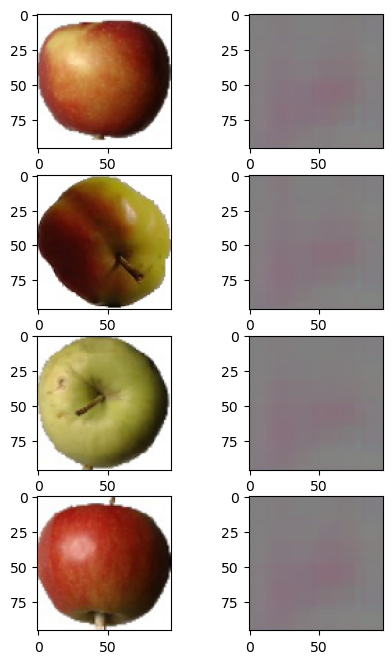

In [23]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [24]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

/var/folders/gw/bdfplx_x79vdn_fy2qsmhwgr0000gn/T/ipykernel_2970/2248427764.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")


Error on validation set:0.11983643472194672, error on anomaly set:0.1810462921857834


# Extracting the encoded image

In [25]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 6, 6, 3)           219       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 3, 3, 3)          

In [26]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [np.reshape(img, (27)) for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [np.reshape(img, (27)) for img in validation_encoded]

anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (27)) for img in anom_encoded]

/var/folders/gw/bdfplx_x79vdn_fy2qsmhwgr0000gn/T/ipykernel_2970/192050118.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_replica.predict_generator(train_generator)
/var/folders/gw/bdfplx_x79vdn_fy2qsmhwgr0000gn/T/ipykernel_2970/192050118.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_encoded = encoder_replica.predict_generator(validation_generator)
/var/folders/gw/bdfplx_x79vdn_fy2qsmhwgr0000gn/T/ipykernel_2970/192050118.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  anom_encoded = encoder_replica.predict_generator(anomaly_generator)


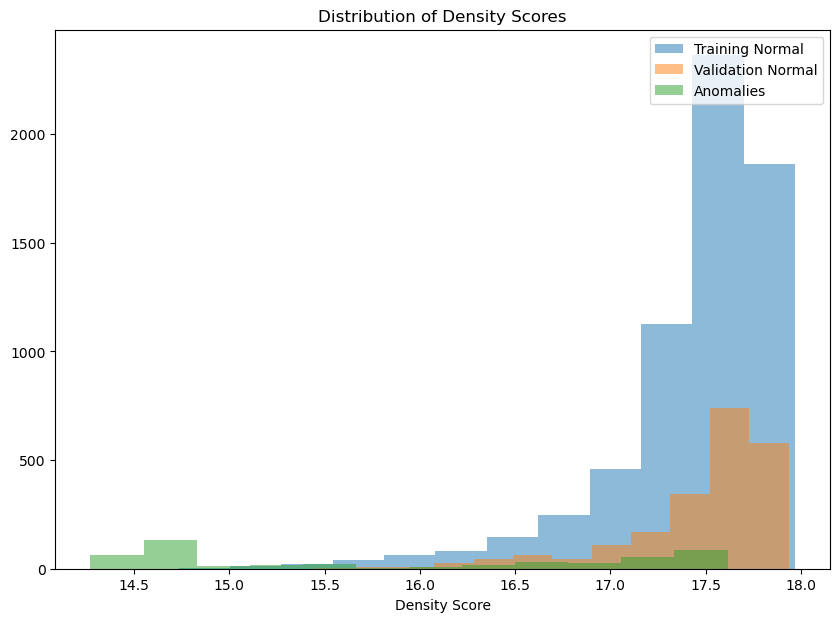

In [27]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [32]:
# Creat a function that will classify whether an unseen image is normal or an anomaly
# Low density and high reconstruction error mean that the image is likely to be anomalous
def check_anomaly(img_path):
    density_threshold = 0 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.04 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    img  = Image.open(img_path)
    img = np.array(img.resize((96,96), Image.Resampling.LANCZOS))
    img = img / 255
    img = np.expand_dims(img, axis=0) # Add batch dimension
    encoded_img = encoder_replica.predict(img) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (27)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
#     print(f'density: {density}')
    reconstruction = model.predict(img)
    reconstruction_error = model.evaluate(img, img, batch_size = 1)
#     print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return True
    else:
        return False


In [33]:
# Check what proportion of onion images are classified as anomalous
onion_files = []
for (dirpath, dirnames, filenames) in os.walk('onions'):
    for x in filenames:
        if x.endswith(".jpg"):
            onion_files.append(os.path.join(dirpath, x))

onion_predictions = []
for file in onion_files:
    onion_predictions.append(check_anomaly(file))
print(sum(onion_predictions)/len(onion_predictions))

1/1 [==============================] - 0s 7ms/step - loss: 0.1568
1.0


In [34]:
# Check what proportion of apples are classified as anomalous (we hope that this will be close to zero)
apples_test = []
for (dirpath, dirnames, filenames) in os.walk('apples_test'):
    for x in filenames:
        if x.endswith(".jpg"):
            apples_test.append(os.path.join(dirpath, x))

apples_predictions = []
for file in apples_test:
    apples_predictions.append(check_anomaly(file))
print(sum(apples_predictions)/len(apples_predictions))

1/1 [==============================] - 0s 7ms/step - loss: 0.1152
1.0


In [35]:
# Check what proportion of aubergines/eggplants get classed as anomalous.
eggplant_test = []
for (dirpath, dirnames, filenames) in os.walk('eggplant'):
    for x in filenames:
        if x.endswith(".jpg"):
            eggplant_test.append(os.path.join(dirpath, x))

eggplant_predictions = []
for file in eggplant_test:
    eggplant_predictions.append(check_anomaly(file))
print(sum(eggplant_predictions)/len(eggplant_predictions))

1/1 [==============================] - 0s 7ms/step - loss: 0.2076
1.0


In [36]:
peppers_test = []
for (dirpath, dirnames, filenames) in os.walk('peppers'):
    for x in filenames:
        if x.endswith(".jpg"):
            peppers_test.append(os.path.join(dirpath, x))

peppers_predictions = []
for file in peppers_test:
    peppers_predictions.append(check_anomaly(file))
print(sum(peppers_predictions)/len(peppers_predictions))

1/1 [==============================] - 0s 7ms/step - loss: 0.1711
1.0


In [37]:
len(peppers_predictions)

592